In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"


In [2]:
!kaggle datasets download -d omkarmanohardalvi/lungs-disease-dataset-4-types # change download site

Dataset URL: https://www.kaggle.com/datasets/omkarmanohardalvi/lungs-disease-dataset-4-types
License(s): unknown
100% 2.01G/2.02G [00:13<00:00, 192MB/s]
100% 2.02G/2.02G [00:13<00:00, 162MB/s]


In [3]:
!unzip lungs-disease-dataset-4-types.zip # change zipped file name

Streaming output truncated to the last 5000 lines.
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0673-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0675-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0678-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0680-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0682-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0683-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0684-0001-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0686-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0690-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0692-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0693-0001.jpeg  
  inflating: Lung Disease Dataset/train/Normal/NORMAL2-IM-0695-0001.jpeg  
  inflating: Lung Disease Dataset/train/Norm

### Import

In [4]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import functional as F
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

### Define Directories

In [5]:
# Define directories
dataset_path = "Lung Disease Dataset"
train_dir = f"{dataset_path}/train"
val_dir = f"{dataset_path}/val"
test_dir = f"{dataset_path}/test"

### Data Preprocessing and Augmentation

In [6]:
# Image size and batch size
image_size = (224, 224)
batch_size = 32

# Define transformations

# Combine all augmentations
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4876, 0.4976, 0.5008], std=[0.2203, 0.2228, 0.2241])
])

valid_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4876, 0.4976, 0.5008], std=[0.2203, 0.2228, 0.2241])
])

# Dataset loading
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
val_dataset = datasets.ImageFolder(val_dir, transform=valid_transform)
test_dataset = datasets.ImageFolder(test_dir, transform=valid_transform)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

### Model Architecture

In [7]:
pip install timm ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.1 MB/s eta 0:00:00


In [8]:
import timm
import torch
import torch.nn as nn

class EfficientNetLiteClassifier(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetLiteClassifier, self).__init__()
        # EfficientNet-Lite model from timm
        self.efficientnet_lite = timm.create_model('efficientnet_lite0', pretrained=True)
        self.efficientnet_lite.classifier = nn.Linear(self.efficientnet_lite.classifier.in_features, num_classes)

    def forward(self, x):
        return self.efficientnet_lite(x)

# Instantiate the model
model = EfficientNetLiteClassifier(num_classes=5)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/18.8M [00:00<?, ?B/s]

### Training Setup

In [9]:
# Hyperparameters and settings
learning_rate = 0.001
num_epochs = 50

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Learning rate scheduler
scheduler_ReduceLROnPlateau = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.path = path

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss:
            if self.verbose:
                print(f"Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}). Saving model...")
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(val_loss, model)
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, val_loss, model):
        torch.save(model.state_dict(), self.path)

# Initialize early stopping
early_stopping = EarlyStopping(patience=10, verbose=True)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print("✅ CUDA is available. Using GPU.")
else:
    print("⚠️ CUDA is not available. Using CPU instead.")

model.to(device)


✅ CUDA is available. Using GPU.


EfficientNetLiteClassifier(
  (efficientnet_lite): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): ReLU6(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): ReLU6(inplace=True)
          )
          (aa): Identity()
          (se): Identity()
          (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn2): BatchNormAct2d(
            16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
       

### Training

In [10]:
# Training function
def train_model(model, train_loader, val_loader, num_epochs=num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(val_acc)
        scheduler_ReduceLROnPlateau.step(val_loss / len(val_loader))

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {running_loss/len(train_loader):.4f}, "
              f"Train Acc: {train_acc:.2f}%, Val Loss: {val_loss/len(val_loader):.4f}, Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'Efficient.pth')

        early_stopping(val_loss / len(val_loader), model)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break

    # Return metrics for external use
    return train_losses, val_losses, train_accuracies, val_accuracies

# Train the model and capture metrics
train_losses, val_losses, train_accuracies, val_accuracies = train_model(model, train_loader, val_loader)


Epoch [1/50], Train Loss: 0.5471, Train Acc: 77.96%, Val Loss: 0.3672, Val Acc: 84.62%
Validation loss decreased (inf --> 0.367181). Saving model...
Epoch [2/50], Train Loss: 0.3720, Train Acc: 85.08%, Val Loss: 0.3434, Val Acc: 85.52%
Validation loss decreased (0.367181 --> 0.343430). Saving model...
Epoch [3/50], Train Loss: 0.3353, Train Acc: 86.14%, Val Loss: 0.3485, Val Acc: 86.61%
EarlyStopping counter: 1 out of 10
Epoch [4/50], Train Loss: 0.3163, Train Acc: 87.33%, Val Loss: 0.2964, Val Acc: 87.00%
Validation loss decreased (0.343430 --> 0.296448). Saving model...
Epoch [5/50], Train Loss: 0.2896, Train Acc: 88.45%, Val Loss: 0.3278, Val Acc: 86.71%
EarlyStopping counter: 1 out of 10
Epoch [6/50], Train Loss: 0.2624, Train Acc: 89.18%, Val Loss: 0.3077, Val Acc: 88.34%
EarlyStopping counter: 2 out of 10
Epoch [7/50], Train Loss: 0.2536, Train Acc: 89.79%, Val Loss: 0.2753, Val Acc: 89.04%
Validation loss decreased (0.296448 --> 0.275267). Saving model...
Epoch [8/50], Train Los

### Plotting Training and Validation Metrics

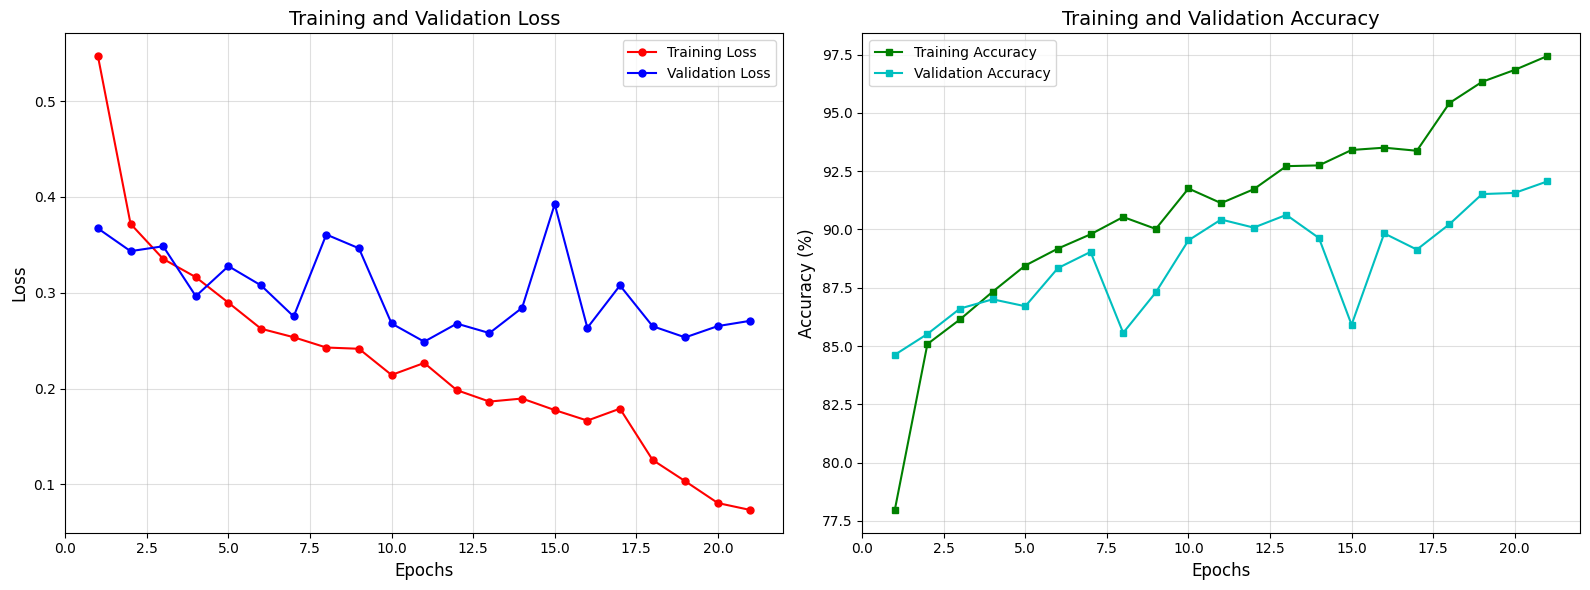

In [11]:
# Function to plot training and validation metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    """
    Plots training and validation loss, as well as training and validation accuracy.

    Parameters:
        train_losses (list): Training loss values for each epoch.
        val_losses (list): Validation loss values for each epoch.
        train_accuracies (list): Training accuracy values for each epoch.
        val_accuracies (list): Validation accuracy values for each epoch.
    """
    epochs = range(1, len(train_losses) + 1)

    # Create a figure with two subplots (1 row, 2 columns)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Plot training and validation loss on the first subplot
    ax1.plot(epochs, train_losses, 'r-o', label='Training Loss', linewidth=1.5, markersize=5)
    ax1.plot(epochs, val_losses, 'b-o', label='Validation Loss', linewidth=1.5, markersize=5)
    ax1.set_title('Training and Validation Loss', fontsize=14)
    ax1.set_xlabel('Epochs', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(alpha=0.4)

    # Plot training and validation accuracy on the second subplot
    ax2.plot(epochs, train_accuracies, 'g-s', label='Training Accuracy', linewidth=1.5, markersize=5)
    ax2.plot(epochs, val_accuracies, 'c-s', label='Validation Accuracy', linewidth=1.5, markersize=5)
    ax2.set_title('Training and Validation Accuracy', fontsize=14)
    ax2.set_xlabel('Epochs', fontsize=12)
    ax2.set_ylabel('Accuracy (%)', fontsize=12)
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(alpha=0.4)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example usage
# Ensure train_losses, val_losses, train_accuracies, and val_accuracies are defined and populated
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)


### Testing

Test Loss: 0.2955, Test Accuracy: 90.72%

Classification Report:
                      precision    recall  f1-score   support

 Bacterial Pneumonia     0.8275    0.8213    0.8244       403
Corona Virus Disease     0.9926    0.9926    0.9926       407
              Normal     0.9007    0.9876    0.9421       404
        Tuberculosis     1.0000    0.9951    0.9975       408
     Viral Pneumonia     0.8049    0.7370    0.7694       403

            accuracy                         0.9072      2025
           macro avg     0.9051    0.9067    0.9052      2025
        weighted avg     0.9055    0.9072    0.9057      2025


Confusion Matrix:


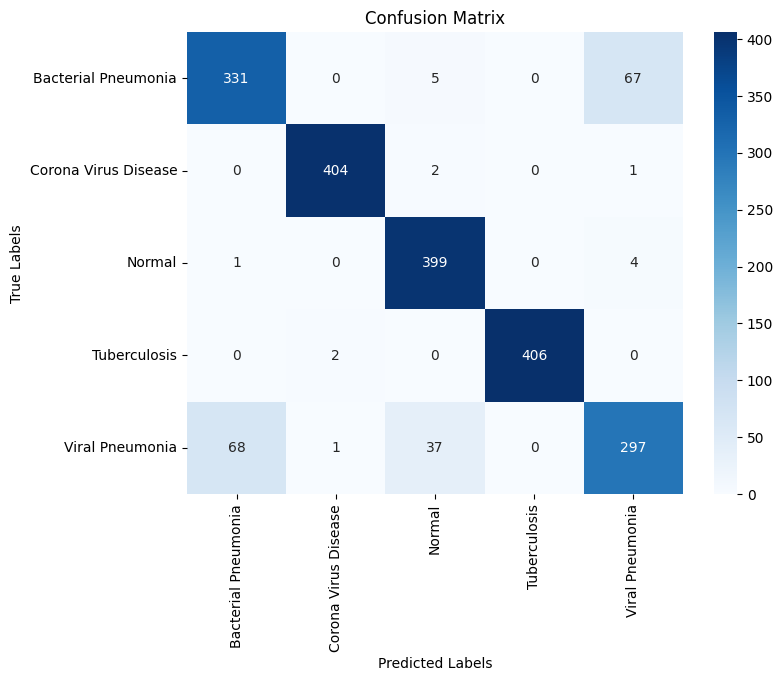

In [12]:
# Test the model
def test_model(model, test_loader, criterion, class_names):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Calculate loss
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Predictions and accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect true and predicted labels
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy and average loss
    test_acc = 100 * correct / total
    avg_loss = total_loss / len(test_loader)

    # Print metrics
    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {test_acc:.2f}%\n")

    # Classification report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # Confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Example usage:
# Assuming your dataset has 'classes' attribute
class_names = test_loader.dataset.classes
test_model(model, test_loader, criterion, class_names)